# GPU Check

In [1]:
import GPUtil
GPUs = GPUtil.getGPUs()
for gpu in GPUs:
  print(gpu.name, gpu.memoryTotal)

Tesla P4 7680.0


# Imports

In [2]:
from SGLD_eval import SGLD, SingleImageDataset
from phantom import generate_phantom
from SGLD_space import DARTS_UNet

from __future__ import print_function
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
from models import *
import torch
import torch.optim
from utils.denoising_utils import *


from nni.retiarii.evaluator.pytorch import Lightning, Trainer
from nni.retiarii.evaluator.pytorch.lightning import DataLoader
from nni.retiarii.experiment.pytorch import RetiariiExperiment, RetiariiExeConfig
from pytorch_lightning.callbacks import ModelCheckpoint
from nni.retiarii.strategy import DARTS as DartsStrategy

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# Search

Using cache found in /home/joe/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:151: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | SGLD | 46.5 M
-------------------------------
46.5 M    Trainable params
0         Non-trainable params
46.5 M    Total params
186.154   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Starting optimization with SGLD


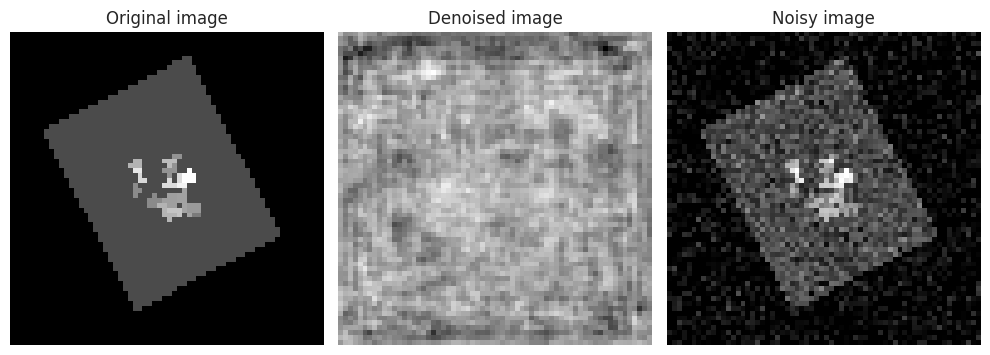

Iter: 0; psnr_gt 10.29; loss 0.10919
Iter: 100; psnr_gt 13.94; loss 0.04541; var 0.34992326
Iter: 200; psnr_gt 14.22; loss 0.04418; var 0.00117073
Iter: 300; psnr_gt 14.24; loss 0.04392; var 0.00000534


In [3]:

# choose iterations
num_iter = 8000 # max iterations

# get image
# generate phantom stored in subfolder of parent directory
resolution = 6
max_depth = resolution - 1
phantom = generate_phantom(resolution=resolution)
raw_img_np = phantom.copy() # 1x64x64 np array    
img_np = raw_img_np.copy() # 1x64x64 np array
sigma=25/255
# sigma = .05
img_noisy_np = np.clip(img_np + np.random.normal(scale=sigma, size=img_np.shape), 0, 1).astype(np.float32)
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

# reference model 
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=64, pretrained=False)

# Create the lightning module
module = SGLD(
        original_np=img_np,
        noisy_np=img_noisy_np,
        noisy_torch=img_noisy_torch,
        learning_rate = 0.1, # .06
        show_every=500,
        patience=1000,
        buffer_size=100,
        # model=model,
        # weight_decay= ((1024**2)/(5e-8)) / (2**resolution) #1.28e-5, # this is for a 64x64 image
        weight_decay= 5e-7
        )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            max_epochs=num_iter,
            fast_dev_run=False,
            gpus=1,
            checkpoint_callback=False
            )

# Initialize ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath='./{lightning_logs}/{logger_name}/version_{version}/checkpoints/',
    filename='{epoch}-{step}',
    every_n_epochs=num_iter/10,
    save_top_k=1,
)

# Add the checkpoint callback to trainer
trainer.callbacks.append(checkpoint_callback)
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = DARTS_UNet(depth=3)

# Select the Search Strategy
strategy = DartsStrategy()

# fast_dev_run=False
search_space=DARTS_UNet()

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

In [ ]:

exported_arch = experiment.export_top_models()

exported_arch

In [ ]:
experiment.stop()